### FashionMNIST cluster based on Kmeans

-FashionMNIST is a dataset of grayscale images of 28x28 pixels representing 10 categories of clothing items.

-Though the dataset provides a label for each image, we can ignore all labels and use only images to do clustering tasks.

-This notebook uses Kmeans to cluster the ten categories of FashionMNIST and compares the results.

### 运行说明：
### 该笔记需要python环境，环境中需确保有torch  matplotlib  torchvision  numpy  sklearn库

==============================================================================================================================================================

In [8]:
import torch
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple
import random

In [9]:
class KMeans:
    def __init__(self, n_clusters: int, max_iters: int = 100, tol: float = 1e-4):
        """
        初始化KMeans类
        
        参数:
        n_clusters: 聚类数量
        max_iters: 最大迭代次数
        tol: 中心点移动的容差阈值
        """
        self.n_clusters = n_clusters
        self.max_iters = max_iters
        self.tol = tol
        self.centroids = None
        self.labels_ = None
        self.inertia_ = None
        
    def _init_centroids(self, X: np.ndarray) -> np.ndarray:
        """
        初始化聚类中心
        使用k-means++算法选择初始中心点
        """
        n_samples, n_features = X.shape
        centroids = []
        
        # 随机选择第一个中心点
        first_centroid_idx = random.randint(0, n_samples-1)
        centroids.append(X[first_centroid_idx])
        
        # 选择其余的中心点
        for _ in range(1, self.n_clusters):
            distances = np.array([min([np.sum((x-c)**2) for c in centroids]) for x in X])
            probabilities = distances / distances.sum()
            cumulative_probs = np.cumsum(probabilities)
            
            # 基于概率选择下一个中心点
            r = random.random()
            for j, p in enumerate(cumulative_probs):
                if r <= p:
                    centroids.append(X[j])
                    break
                    
        return np.array(centroids)
    
    def _assign_clusters(self, X: np.ndarray, centroids: np.ndarray) -> Tuple[np.ndarray, float]:
        """
        将每个样本分配到最近的中心点
        
        返回:
        labels: 样本的类别标签
        inertia: 样本到其最近中心点的距离平方和
        """
        distances = np.sqrt(((X - centroids[:, np.newaxis])**2).sum(axis=2))
        labels = np.argmin(distances, axis=0)
        inertia = np.sum(np.min(distances, axis=0)**2)
        return labels, inertia
    
    def _update_centroids(self, X: np.ndarray, labels: np.ndarray) -> np.ndarray:
        """
        更新聚类中心点
        """
        new_centroids = np.array([X[labels == k].mean(axis=0) for k in range(self.n_clusters)])
        # 处理空簇的情况
        mask = np.isnan(new_centroids).any(axis=1)
        new_centroids[mask] = self.centroids[mask]
        return new_centroids
    
    def fit(self, X: np.ndarray) -> 'KMeans':
        """
        执行K-means聚类
        """
        # 初始化中心点
        self.centroids = self._init_centroids(X)
        
        for iteration in range(self.max_iters):
            old_centroids = self.centroids.copy()
            
            # 分配样本到最近的簇
            self.labels_, self.inertia_ = self._assign_clusters(X, self.centroids)
            
            # 更新中心点
            self.centroids = self._update_centroids(X, self.labels_)
            
            # 检查收敛
            if np.sum((self.centroids - old_centroids)**2) < self.tol:
                print(f"Converged at iteration {iteration}")
                break
                
        return self

In [12]:
# 数据加载和预处理
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.FashionMNIST(root='./fmnist_data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=len(train_dataset))

In [13]:
# 获取完整数据集
images, labels = next(iter(train_loader))
x_train = images.numpy().reshape(len(images), -1)

# 类别名称
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [14]:
# 执行聚类
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, max_iters=100)
kmeans.fit(x_train)
cluster_labels = kmeans.labels_

Converged at iteration 51


In [15]:
# 可视化函数
def visualize_clustering_results(images: np.ndarray, 
                               cluster_labels: np.ndarray, 
                               true_labels: np.ndarray,
                               centroids: np.ndarray):
    """
    可视化聚类结果和中心点
    """
    plt.figure(figsize=(25, 20))
    
    # 可视化聚类中心
    for i in range(n_clusters):
        plt.subplot(n_clusters + 1, 6, i + 1)
        plt.imshow(centroids[i].reshape(28, 28), cmap='gray')
        plt.title(f'Centroid {i}')
        plt.axis('off')
    
    # 可视化每个簇的样本
    for i in range(n_clusters):
        cluster_images = images[cluster_labels == i]
        cluster_true_labels = true_labels[cluster_labels == i]
        
        # 获取该簇中最常见的真实标签
        if len(cluster_true_labels) > 0:
            most_common_label = np.bincount(cluster_true_labels).argmax()
            most_common_name = class_names[most_common_label]
        else:
            most_common_name = "Empty Cluster"
        
        # 显示每个簇的5个样本
        for j in range(5):
            if j < len(cluster_images):
                plt.subplot(n_clusters + 1, 6, (i+1)*6 + j + 1)
                plt.imshow(cluster_images[j].reshape(28, 28), cmap='gray')
                if j == 0:
                    plt.title(f'Cluster {i}\n{most_common_name}\nSize: {len(cluster_images)}')
                plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# 计算聚类统计信息
def print_cluster_statistics(cluster_labels: np.ndarray, 
                           true_labels: np.ndarray):
    """
    打印每个簇的详细统计信息
    """
    print("\nCluster Statistics:")
    print("-" * 50)
    
    for i in range(n_clusters):
        cluster_true_labels = true_labels[cluster_labels == i]
        cluster_size = len(cluster_true_labels)
        
        if cluster_size > 0:
            unique_labels, counts = np.unique(cluster_true_labels, return_counts=True)
            top_3_idx = np.argsort(-counts)[:3]
            
            print(f"\nCluster {i}:")
            print(f"Total items: {cluster_size}")
            print("Top 3 classes:")
            for idx in top_3_idx:
                label = unique_labels[idx]
                percentage = (counts[idx] / cluster_size) * 100
                print(f"- {class_names[label]}: {percentage:.1f}%")

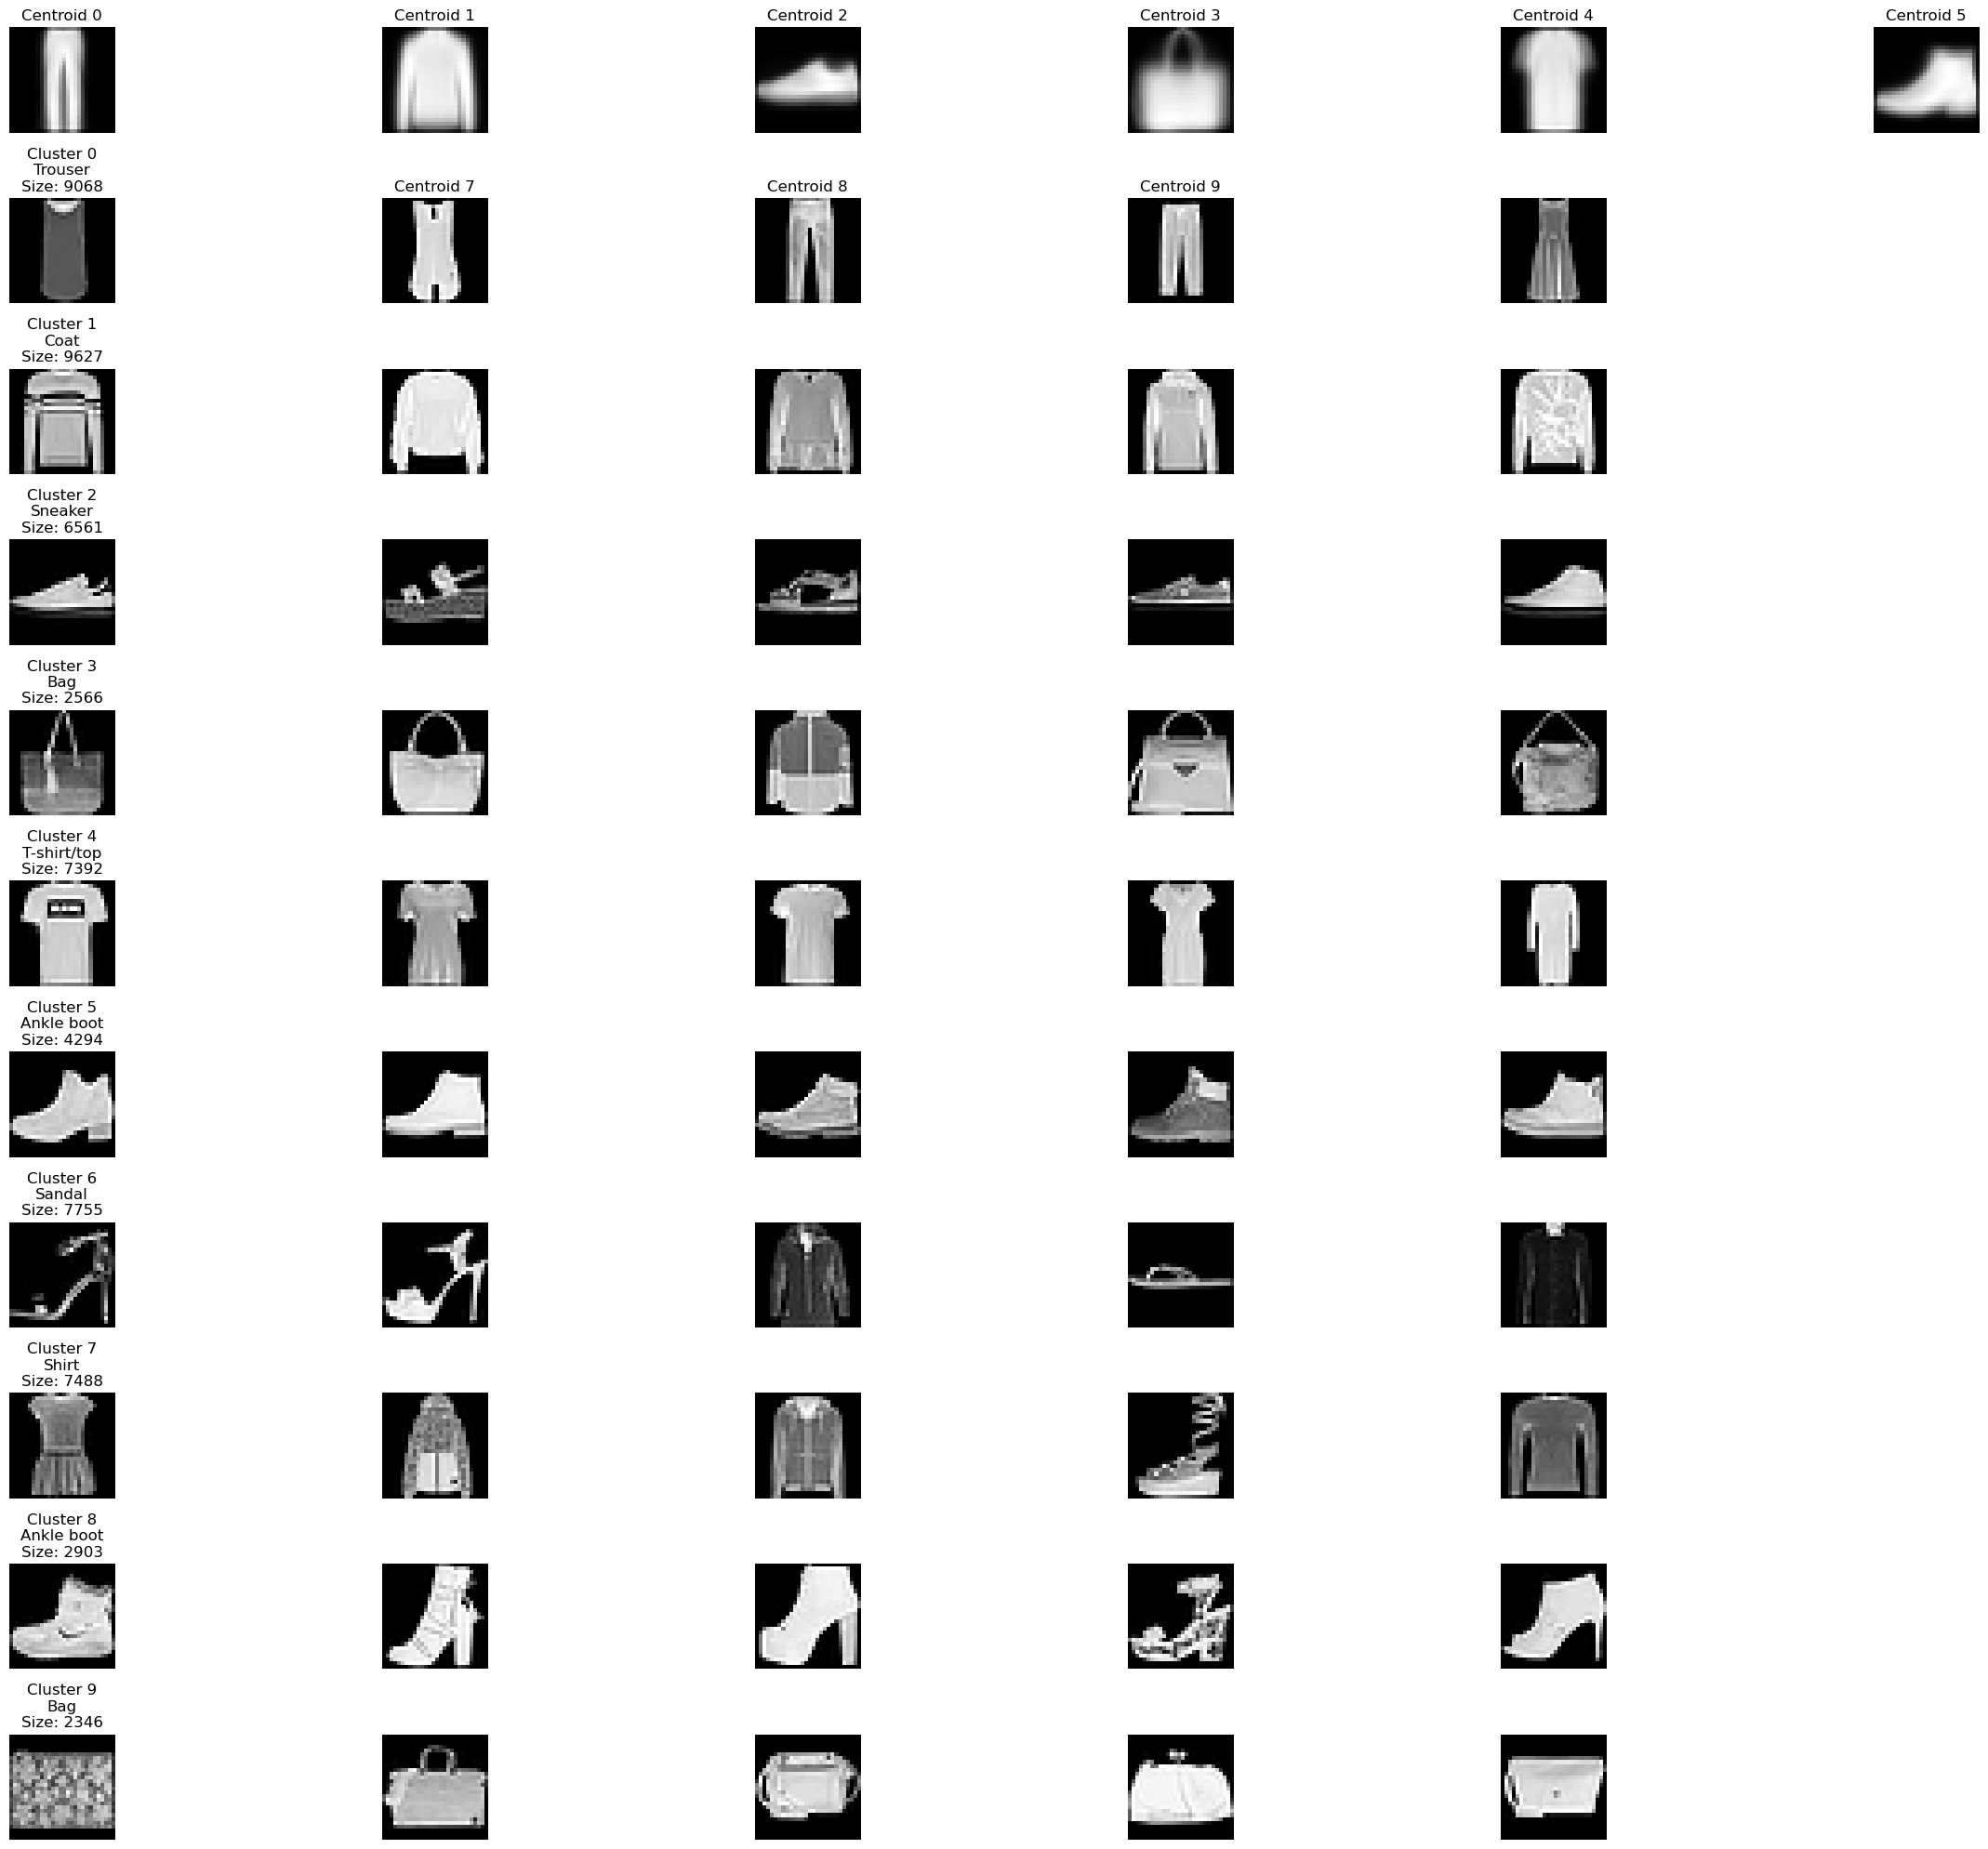


Cluster Statistics:
--------------------------------------------------

Cluster 0:
Total items: 9068
Top 3 classes:
- Trouser: 59.7%
- Dress: 35.3%
- T-shirt/top: 2.2%

Cluster 1:
Total items: 9627
Top 3 classes:
- Coat: 37.4%
- Pullover: 36.6%
- Shirt: 20.3%

Cluster 2:
Total items: 6561
Top 3 classes:
- Sneaker: 71.6%
- Sandal: 21.9%
- Bag: 3.6%

Cluster 3:
Total items: 2566
Top 3 classes:
- Bag: 95.3%
- Coat: 1.1%
- T-shirt/top: 1.1%

Cluster 4:
Total items: 7392
Top 3 classes:
- T-shirt/top: 46.1%
- Dress: 22.8%
- Shirt: 14.2%

Cluster 5:
Total items: 4294
Top 3 classes:
- Ankle boot: 69.7%
- Sneaker: 17.8%
- Sandal: 11.1%

Cluster 6:
Total items: 7755
Top 3 classes:
- Sandal: 48.7%
- Shirt: 9.9%
- T-shirt/top: 7.6%

Cluster 7:
Total items: 7488
Top 3 classes:
- Shirt: 27.7%
- Pullover: 23.8%
- T-shirt/top: 21.2%

Cluster 8:
Total items: 2903
Top 3 classes:
- Ankle boot: 90.1%
- Sandal: 8.9%
- Sneaker: 0.8%

Cluster 9:
Total items: 2346
Top 3 classes:
- Bag: 93.9%
- Shirt: 2.6%
- 

In [16]:
# 显示结果
visualize_clustering_results(x_train, kmeans.labels_, labels.numpy(), kmeans.centroids)
print_cluster_statistics(kmeans.labels_, labels.numpy())

# 计算轮廓系数
from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(x_train, kmeans.labels_)
print(f"\nSilhouette Score: {silhouette_avg:.3f}")